In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy
from numba import jit, objmode, njit, prange
import pandas as pd

In [2]:
THIS = 'dissipation-theory--Study-57--'
figs = {}

# Newton-Cotes integration

We wish to compute a numerical approximation to the following unitless integral:

\begin{equation}
{\cal I}_{\ell}(x) = \int_{0}^{\infty} dy \, y^{\ell} e^{-y} J_{0}(y \, x).
\end{equation}

Define a function to rapidly evaluate the integrand.

In [3]:
@jit(nopython=True)
def integrand(ell, y, x):
    return y**ell * np.exp(-y) * scipy.special.j0(y * x)

Plot the ${\cal I}_{\ell}$ integrand for various $x$. Set the number of points $N$ and the $y$-axis maximum $y_{\mathrm{max}}$.

In [301]:
def plotme(N, ymax):

    with plt.style.context('seaborn-v0_8'):

        fig, axs = plt.subplots(1, 3, figsize=(3.50 * 3, 3.5), sharey=True)

        y = np.linspace(0, ymax, N)
        for index in [0, 1, 2]:
            for x in [0., 2., 5.]:
                axs[index].plot(y, np.array([integrand(index, y_, x) for y_ in y]), '-', label='x = {:0.1f}'.format(x))
            
            axs[index].set_ylabel('${\cal I}_{' + '{:d}'.format(index) + '}$ integrand')
            axs[index].set_xlabel('$y$')
            axs[index].legend(frameon=True, facecolor="lightgray", framealpha=0.8)

        fig.tight_layout()
        
        return fig

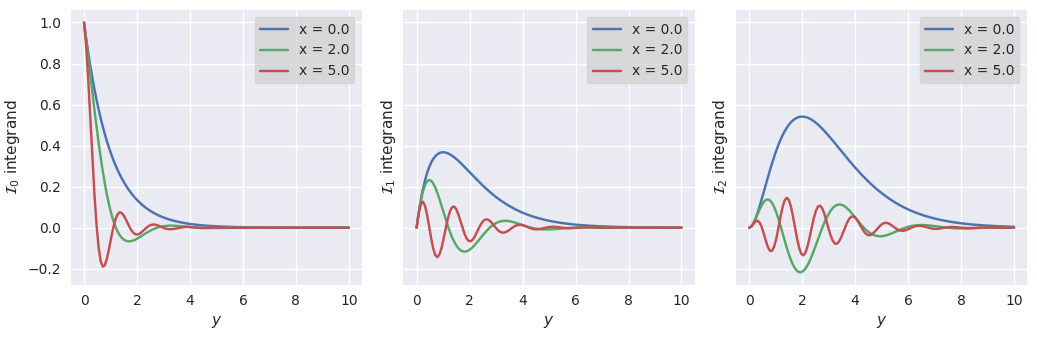

In [302]:
figs['01'] = plotme(128, 10.)
figs['01']

The integral has the following analytical solutions:
\begin{equation}
{\cal I}_{0}^{\mathrm{calc}}(x) = \frac{1}{(1 + x^2)^{1/2}}, \text{ }
{\cal I}_{1}^{\mathrm{calc}}(x) = \frac{1}{(1 + x^2)^{3/2}}, \text{ and }
{\cal I}_{2}^{\mathrm{calc}}(x) = \frac{2 - x^2}{(1 + x^2)^{5/2}}
\end{equation}
Code these solutions into the following function.

In [14]:
@jit(nopython=True)
def Iexact(ell, x):
    if ell == 0:
        return np.power(1 + x**2, -1/2)
    elif ell == 1:
        return np.power(1 + x**2, -3/2)
    elif ell == 2:
        return (2 - x**2) * np.power(1 + x**2, -5/2)

In [19]:
Iexact(0,10.)

0.09950371902099892

A function to perform (non-adaptive) Newton-Cotes integration.

In [34]:
@jit(nopython=True)
def Imockup(ell, x, an, ymax):
    
    N = len(an) - 1
    y_vector = np.linspace(0., ymax, N+1)
    dy = ymax / N
    
    integral = np.zeros_like(y_vector)
    for m, y in enumerate(y_vector):
        integral[m] = integrand(ell, y, x)
    
    return dy * (an * integral).sum()

A function to compute, and display, the relative error in $b$ with $a$ as the ground truth.

In [33]:
def compare(a, b):
    epsilon = (a-b)/a
    print("a = {:+0.6f}  b = {:+0.6f}  epsilon {:+0.1e}".format(a, b, epsilon))

Test drive the integrator with $N = 30$, $y_{\mathrm{max}} = 20$ and $\ell = 0$, and $x = 2$.

In [32]:
an, _ = scipy.integrate.newton_cotes(30, 1)
compare(
    Iexact(0, 2.),
    Imockup(0, 2., an, 20.))

a = +0.447214  b = +0.447449  epsilon -5.3e-04


Make a table of **relative error** for the Newton-Cotes method ($N = 20$, $y_{\mathrm{max}} = 20.$)

In [122]:
N = 20
ymax = 20.

x_value = [0., 0.12, 0.25, 0.5, 1., 1.5, 2., 3., 4, 5.]
ell_value = [0, 1, 2]
data = np.zeros((len(x_value),len(ell_value)))
    
an, _ = scipy.integrate.newton_cotes(N, 1)

for j, x in enumerate(x_value):
    for k, ell in enumerate(ell_value):
        a = Iexact(ell, x)
        b = Imockup(ell, x, an, ymax).real
        data[j,k] = (a-b)/a

pd.options.display.float_format = '{:.1e}'.format
df = pd.DataFrame(data, columns=ell_value, index=x_value)
df

,0,1,2
0.0e+00,-2.1e-07,3.0e-06,-1.7e-05
1.2e-01,-9.6e-08,1.7e-06,-1.2e-05
2.5e-01,1.5e-07,-1.7e-06,6.2e-06
5.0e-01,-5.5e-07,2.2e-06,4.9e-05
1.0e+00,5.6e-05,3.6e-04,-2.6e-02
1.5e+00,5.8e-03,3.0e-02,1.4e+01
2.0e+00,7.6e-02,5.7e+00,-5.8e+01
3.0e+00,1.6e+00,1.3e+01,1.2e+02
4.0e+00,-4.7e-02,-7.6e+01,3.2e+02
5.0e+00,2.5e-01,1.5e+01,-2.0e+01


At $x = 0.12$, the function $J_{0}(x \, y)$ has its first zero just inside $y = 20$. \
The above table suggests that $N = 20$ is sufficient to reach $|\epsilon| \leq 10^{-7}$ accuracy when integrating the full integrand between 0 and the first Bessel-function zero.

# Develop adaptive integration

The first $40$ zeros $j_{0,n}$ of the $J_0$ Bessel function.

In [58]:
scipy.special.jn_zeros(0,40)

array([  2.40482556,   5.52007811,   8.65372791,  11.79153444,
        14.93091771,  18.07106397,  21.21163663,  24.35247153,
        27.49347913,  30.63460647,  33.77582021,  36.91709835,
        40.05842576,  43.19979171,  46.34118837,  49.4826099 ,
        52.62405184,  55.76551076,  58.90698393,  62.04846919,
        65.1899648 ,  68.33146933,  71.4729816 ,  74.61450064,
        77.75602563,  80.89755587,  84.03909078,  87.18062984,
        90.32217264,  93.46371878,  96.60526795,  99.74681986,
       102.88837425, 106.02993092, 109.17148965, 112.31305028,
       115.45461265, 118.59617663, 121.73774209, 124.87930891])

For $x = 3$, how many zeroes of $J_{0}( x \, y)$ are occur for $y \leq y_{\mathrm{max}}$, with $y_{\mathrm{max}} = 20$.

In [94]:
j0s = scipy.special.jn_zeros(0,100.)

x, y_max = 3., 20.
    
mask = j0s/x < y_max
j0s[mask].shape

(19,)

Return the y breakpoints where $y \, x = j_{0,n}$.

In [95]:
y_breakpoints0 = j0s[mask] / x
y_breakpoints0

array([ 0.80160852,  1.84002604,  2.88457597,  3.93051148,  4.97697257,
        6.02368799,  7.07054554,  8.11749051,  9.16449304, 10.21153549,
       11.25860674, 12.30569945, 13.35280859, 14.39993057, 15.44706279,
       16.4942033 , 17.54135061, 18.58850359, 19.63566131])

Prepend $0$ and append $y_{\mathrm{max}}$ to this list.  The `np.insert` and `np.append` command return a new array, so could slow down a big loop.  Google AI suggests that "Appending repeatedly in a loop can be inefficient because a new array is created and data is copied in each iteration."

In [102]:
%%timeit
y_breakpoints = np.insert(y_breakpoints0, 0, 0.)
y_breakpoints = np.append(y_breakpoints, y_max)

27 μs ± 4.94 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [106]:
y_breakpoints

array([ 0.        ,  0.80160852,  1.84002604,  2.88457597,  3.93051148,
        4.97697257,  6.02368799,  7.07054554,  8.11749051,  9.16449304,
       10.21153549, 11.25860674, 12.30569945, 13.35280859, 14.39993057,
       15.44706279, 16.4942033 , 17.54135061, 18.58850359, 19.63566131,
       20.        ])

Google AI recommends `numpy.concatenate()`, `numpy.vstack()`, or `numpy.hstack()`.  Do some reading and try just `numpy.hstack`.

In [104]:
%%timeit
y_breakpoints = np.hstack((0., y_breakpoints0, y_max))

10.2 μs ± 1.96 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [105]:
y_breakpoints

array([ 0.        ,  0.80160852,  1.84002604,  2.88457597,  3.93051148,
        4.97697257,  6.02368799,  7.07054554,  8.11749051,  9.16449304,
       10.21153549, 11.25860674, 12.30569945, 13.35280859, 14.39993057,
       15.44706279, 16.4942033 , 17.54135061, 18.58850359, 19.63566131,
       20.        ])

We can see that the `.hstack` method is 2.5-fold faster than the `.insert` and `.append` method.

Ok, now develop an algorithm that breaks the integrand into regions spanned by the breakpoints.

In [182]:
N = 20
an, _ = scipy.integrate.newton_cotes(N, 1)
len(an)

21

Pick $x = 1.50$ as a represntative test case where the relative error starts to be bad but there are not *too many* breakpoints.

In [169]:
ell = 0
x = 1.50

Compute the breakpoints using the code develope above.

In [170]:
mask = j0s/x < y_max
yb = np.hstack((0., j0s[mask] / x, y_max))
yb

array([ 0.        ,  1.60321704,  3.68005207,  5.76915194,  7.86102296,
        9.95394514, 12.04737598, 14.14109109, 16.23498102, 18.32898609,
       20.        ])

In [171]:
len(yb)

11

This is how we can cycle through the breakpoints.

In [172]:
for index in np.arange(len(y_breakpoints)-1):
    print(index, yb[index],yb[index+1])

0 0.0 1.6032170384638487
1 1.6032170384638487 3.680052073524207
2 3.680052073524207 5.769151941940675
3 5.769151941940675 7.861022959342854
4 7.861022959342854 9.953945138991857
5 9.953945138991857 12.047375978607283
6 12.047375978607283 14.141091086586172
7 14.141091086586172 16.234981020499536
8 16.234981020499536 18.328986088026838
9 18.328986088026838 20.0


Now write a function to cycle through the breakpoint intervals, and integrate each one separately.

In [179]:
result = np.zeros(len(y_breakpoints)-1)
for index in np.arange(len(y_breakpoints)-1):
    
    y_vector = np.linspace(y_breakpoints[index], y_breakpoints[index+1], N+1)
    dy = (y_breakpoints[index+1] - y_breakpoints[index])/N

    integral = np.zeros_like(y_vector)
    for m, y in enumerate(y_vector):
        integral[m] = integrand(ell, y, x)
    
    result[index] = dy * (an * integral).sum()

Here `result` is an array of integrals over the subintervals. \
As we expect, the integrals alternate sign, because at each breakpoint the Bessel function $J_0$ has a zero crossing.

In [181]:
result

array([ 5.94891100e-01, -4.38331019e-02,  4.01284341e-03, -4.10396345e-04,
        4.41426631e-05, -4.88707858e-06,  5.51268224e-07, -6.30041798e-08,
        7.27089050e-09, -8.11535898e-10])

Add all the results up to get the total integral, and compare to the eact result.

In [178]:
compare(result.sum(), Iexact(ell, x))

a = +0.554700  b = +0.554700  epsilon -9.3e-10


Wow, the accuracy $|\epsilon| = 9.3 \times 10^{-10}$ is fantastic, a huge improvement over the $|\epsilon| = 5.8 \times 10^{-3}$ seen in the one-step integration above.

Now turn the above algorithm into code.  To get the code to compile, I had to replace

    yb = np.hstack((0., j0s[mask] / x, y_max))

by 

    yb = np.hstack(
        (np.array([0.]),
         j0s[mask] / x,
         np.array([y_max])))
         
because, I inferred from the error message, that `jit` was having trouble with passing a tuple containing mixed data types to the `np.hstack` function.  

Add a small amount to $x$ to avoid a divide-by-zero error in the `j0s/x` computation.

In [272]:
@jit(nopython=True)
def Imockup2(ell, x, an, ymax, j0s):

    mask = j0s/(x + 1.0e-6) < y_max
    yb = np.hstack(
        (np.array([0.]),
         j0s[mask] / x,
         np.array([y_max])))
    
    result = np.zeros(len(yb)-1)
    for index in np.arange(len(yb)-1):
        
        y_vector = np.linspace(yb[index], yb[index+1], N+1)
        dy = (yb[index+1] - yb[index])/N
    
        integral = np.zeros_like(y_vector)
        for m, y in enumerate(y_vector):
            integral[m] = integrand(ell, y, x)
        
        result[index] = dy * (an * integral).sum()

    return result.sum()

Make sure we recover the above result.

In [273]:
an, _ = scipy.integrate.newton_cotes(N, 1)
j0s = scipy.special.jn_zeros(0,100.)

compare(
    Imockup2(0, 1.5, an, 20., j0s),
    Iexact(0, 1.5))


a = +0.554700  b = +0.554700  epsilon -9.3e-10


Reproduce the above table using the new integral function, except now give the relative error $\epsilon$ in **parts per million**.

In [274]:
N = 20
ymax = 20.
an, _ = scipy.integrate.newton_cotes(N, 1)

x_value = [0., 0.12, 0.25, 0.5, 1., 1.5, 2., 3., 4, 5., 10.]
ell_value = [0, 1, 2]
data = np.zeros((len(x_value),len(ell_value)))
    
an, _ = scipy.integrate.newton_cotes(N, 1)

for j, x in enumerate(x_value):
    for k, ell in enumerate(ell_value):
        a = Iexact(ell, x)
        b = Imockup2(ell, x, an, ymax, j0s).real
        data[j,k] = 1e6 * (a-b)/a

pd.options.display.float_format = '{:.3f}'.format
df = pd.DataFrame(data, columns=ell_value, index=x_value)
df

,0,1,2
0.000,-0.211,2.958,-17.340
0.120,-0.096,1.660,-12.463
0.250,0.000,-0.003,-0.045
0.500,0.000,-0.012,-0.189
1.000,0.001,0.007,0.232
1.500,0.001,0.008,-1.934
2.000,0.001,-0.022,1.164
3.000,0.001,-0.030,0.858
4.000,0.001,0.027,-0.657
5.000,0.001,0.086,-1.934


**Fantasic performance, all errors under 20 ppm, all the way up to $x = 10$.**

Do a quick timing check.  First, an easy one, where there are no integration breakpoints.

In [247]:
%%timeit
Imockup2(0, 0.12, an, 20., j0s)

3.97 μs ± 729 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Now two hard ones, with many integration breakpoints.

In [248]:
%%timeit
Imockup2(0, 3.0, an, 20., j0s)

38.6 μs ± 5.14 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [249]:
%%timeit
Imockup2(0, 5.0, an, 20., j0s)

62.1 μs ± 2 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The harder one takes longer, because we have to break the integral up into smaller pieces.

See if we can speed the integration up some more with parallel processing.

In [235]:
@njit(parallel=True)
def Imockup3(ell, x, an, ymax, j0s):

    mask = j0s/x < y_max
    yb = np.hstack(
        (np.array([0.]),
         j0s[mask] / x,
         np.array([y_max])))

    result = np.zeros(len(yb)-1)
    for index in prange(len(yb)-1):
        
        y_vector = np.linspace(yb[index], yb[index+1], N+1)
        dy = (yb[index+1] - yb[index])/N
    
        integral = np.zeros_like(y_vector)
        for m in prange(len(y_vector)):
            integral[m] = integrand(ell, y_vector[m], x)
        
        result[index] = dy * (an * integral).sum()

    return result.sum()

Make sure we get the above result.

In [236]:
an, _ = scipy.integrate.newton_cotes(N, 1)
j0s = scipy.special.jn_zeros(0,100.)

compare(
    Imockup3(0, 1.5, an, 20., j0s),
    Iexact(0, 1.5))

a = +0.554700  b = +0.554700  epsilon -9.3e-10


Reproduce the error table with the new parallized function.

In [279]:
N = 20
ymax = 20.
an, _ = scipy.integrate.newton_cotes(N, 1)

x_value = [0., 0.12, 0.25, 0.5, 1., 1.5, 2., 3., 4, 5., 10.]
ell_value = [0, 1, 2]
data = np.zeros((len(x_value),len(ell_value)))
    
an, _ = scipy.integrate.newton_cotes(N, 1)

for j, x in enumerate(x_value):
    for k, ell in enumerate(ell_value):
        a = Iexact(ell, x)
        b = Imockup3(ell, x, an, ymax, j0s).real
        data[j,k] = 1e6 * (a-b)/a

pd.options.display.float_format = '{:.5f}'.format
df = pd.DataFrame(data, columns=ell_value, index=x_value)
df

,0,1,2
0.00000,-0.21064,2.95761,-17.34023
0.12000,-0.09613,1.66047,-12.46288
0.25000,0.00003,-0.00347,-0.04540
0.50000,0.00013,-0.01163,-0.18859
1.00000,0.00097,0.00702,0.23217
1.50000,0.00093,0.00782,-1.93363
2.00000,0.00061,-0.02195,1.16445
3.00000,0.00068,-0.02952,0.85792
4.00000,0.00091,0.02713,-0.65696
5.00000,0.00100,0.08627,-1.93369


In [300]:
 df.index.values

array([ 0.  ,  0.12,  0.25,  0.5 ,  1.  ,  1.5 ,  2.  ,  3.  ,  4.  ,
        5.  , 10.  ])

In [294]:
df[0].values

array([-2.10641912e-01, -9.61339195e-02,  3.23482913e-05,  1.29328113e-04,
        9.66356581e-04,  9.33563334e-04,  6.14036452e-04,  6.82282386e-04,
        9.09269215e-04,  9.97840391e-04,  9.43016364e-04])

In [351]:
def plotme(df):
    x = df.index.values
    with plt.style.context('seaborn-v0_8'):

        fig = plt.figure(figsize=(3.25, 3.50))  
        
        for key in df.columns.tolist():
            y = 1e-6 * np.abs(df[key].values)
            plt.loglog(x, y, 'o-', label=key)

        plt.xlabel('$x$')
        plt.ylabel('fractional error |$\epsilon$|')
        plt.legend(frameon=True, facecolor="lightgray", framealpha=0.8, ncol=3, fontsize=9)
        fig.tight_layout()
        
        return fig

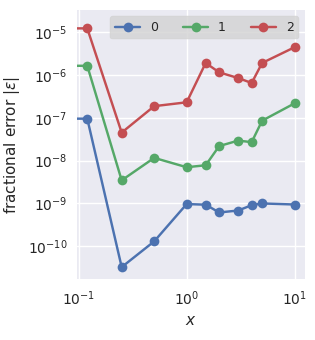

In [352]:
figs['02'] = plotme(df)
figs['02']

Do the same two timing checks. \
This first one should be compared to 3.97 μs per loop for `Imockup2`.

In [251]:
%%timeit
Imockup3(0, 0.12, an, 20., j0s)

445 μs ± 62.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


This second one should be compared to 38.6 μs μs per loop for `Imockup2`.

In [252]:
%%timeit
Imockup3(0, 3.0, an, 20., j0s)

488 μs ± 68.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


This third one should be compared to 62.1 μs ± 20.9 μs per loop for `Imockup2`.

In [253]:
%%timeit
Imockup3(0, 5.0, an, 20., j0s)

532 μs ± 89.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Compiling with parallelization *seems* to slow down execution, but the performance is essentially independent of the number of breakpoints, which is interesting.  I conclude that the timing may reflect overhead, not the underlying time per loop.  When I add two additional loops to cycle over the image-charge and voltage-test vectors, I should compare the unparallelized and parallelized code carefully again.

We can perform a quick best-case and worst-case timing analysis for $N_{\mathrm{total}} = 15 \times 20 = 300$ loops, appropriate for the calculation of the capacitance of a sphere above a ground plane.  Remember to include a factor of 3 for the three $K_n$ components.  The execution speed depends critically on $x$.  The best case is where $x$ is small and there are no breakpoints.  The worse case is where $x$ is large and there are many breakpoints.  Pick $x = 5$, corresponding to $h = 0.1 R$, as a worse-case situation.  Use the `Imockup2` timings.

* (best case, $x \leq 0.12$) 4 us x 300 x 3 = 3.6 ms
* (worse case, $x = 3$) 62 us x 300 x 3 = 56 ms

Both these times are acceptable.

::: {.content-hidden when-format="html"}

# Save the figures

In [353]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-57.ipynb && open dissipation-theory--Study-57.html
    
:::